<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2021/blob/main/04_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial is building on top of [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning) keras tutorial and [The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions](https://www.nature.com/articles/sdata2018161) dataset (downloaded from [HAM10000 ImageNet-style dataset](https://www.kaggle.com/umangjpatel/ham10000-imagenet-style-dataset) kaggle dataset). Only small subset of original data is used: class `df` with 115 images, class `vasc` with 142 images and class `akiec` with 327 images.

## Setup


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from keras import regularizers
import keras

## Data preparation

In [3]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from pathlib import Path

_URL = 'https://github.com/ML-Bioinfo-CEITEC/ECCB2021/raw/main/data/HAM10000/'
PATH = Path('/content/datasets/HAM10000')
for split in ['train', 'val']:
  Path(PATH / split).mkdir(parents=True, exist_ok=True)
  for zip_file in ['akiec.zip', 'df.zip', 'vasc.zip']:
    with urlopen(_URL + split + '/' + zip_file) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(PATH / split)

In [31]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [32]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 466 files belonging to 3 classes.


In [33]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 118 files belonging to 3 classes.


Show the first nine images and labels from the training set:

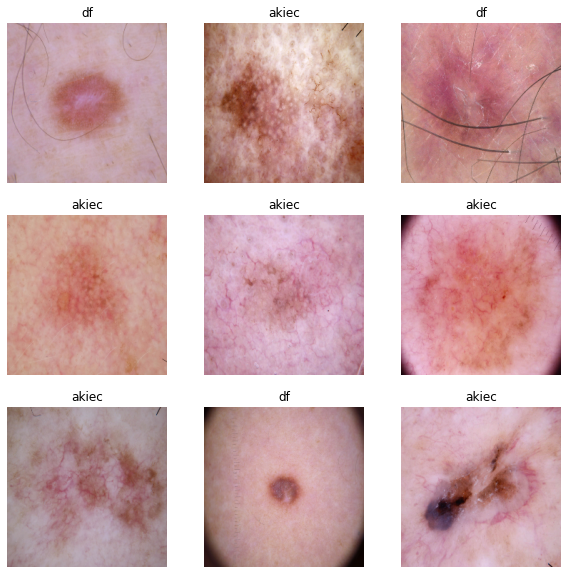

In [34]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data augmentation


When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [35]:
#TODO: explain augmentation in slides first
#TODO: what augmentation to use for this biological data?
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call model.fit. They are inactive when the model is used in inference mode in model.evaulate or model.fit.

Let's repeatedly apply these layers to the same image and see the result.

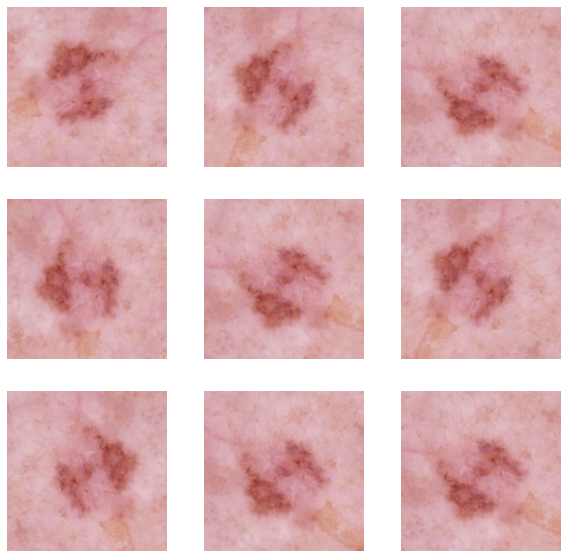

In [36]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Create the base model from the pre-trained model

In [37]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

This feature extractor converts each 100x100x3 image into a 
4x4x1280 block of features. Let's see what it does to an example batch of images:

In [38]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [39]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [41]:
NUM_LABELS = 3
prediction_layer = tf.keras.layers.Dense(NUM_LABELS, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In a moment, you will download tf.keras.applications. MobileNetV2 for use as your base model. This model expects pixel values in [-1,1], but at this point, the pixel values in your images are in [0-255]. To rescale them, use the preprocessing method included with the model.

In [42]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [43]:
#TODO: unify
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [44]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

## Train the model

In [46]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
15/15 [==============================] - 20s 1s/step - loss: 1.4567 - accuracy: 0.2554 - val_loss: 1.0872 - val_accuracy: 0.3729
Epoch 2/10
15/15 [==============================] - 17s 1s/step - loss: 1.2614 - accuracy: 0.3970 - val_loss: 0.9883 - val_accuracy: 0.5254
Epoch 3/10
15/15 [==============================] - 17s 1s/step - loss: 1.1486 - accuracy: 0.4936 - val_loss: 0.9233 - val_accuracy: 0.5678
Epoch 4/10
15/15 [==============================] - 17s 1s/step - loss: 1.0506 - accuracy: 0.5343 - val_loss: 0.8605 - val_accuracy: 0.5678
Epoch 5/10
15/15 [==============================] - 17s 1s/step - loss: 0.9937 - accuracy: 0.5622 - val_loss: 0.8098 - val_accuracy: 0.6271
Epoch 6/10
15/15 [==============================] - 17s 1s/step - loss: 0.9044 - accuracy: 0.6052 - val_loss: 0.7676 - val_accuracy: 0.6441
Epoch 7/10
15/15 [==============================] - 16s 1s/step - loss: 0.8640 - accuracy: 0.6266 - val_loss: 0.7308 - val_accuracy: 0.6949
Epoch 8/10
15/15 [==

### Plot learning curves

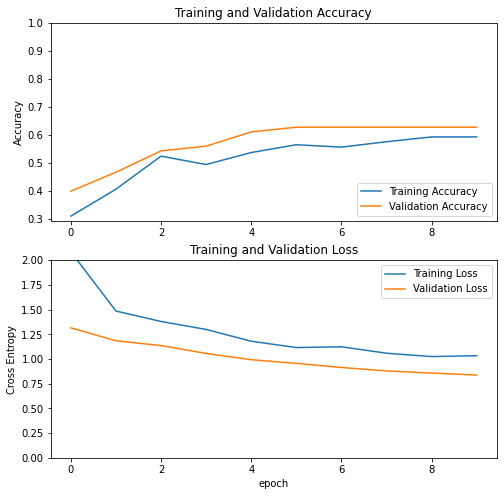

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [47]:
base_model.trainable = True

In [48]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model


As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [49]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

### Continue training the model


If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.



In [51]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
15/15 [==============================] - 21s 1s/step - loss: 0.6874 - accuracy: 0.7361 - val_loss: 0.5909 - val_accuracy: 0.7966
Epoch 11/20
15/15 [==============================] - 18s 1s/step - loss: 0.6056 - accuracy: 0.7704 - val_loss: 0.5626 - val_accuracy: 0.8051
Epoch 12/20
15/15 [==============================] - 18s 1s/step - loss: 0.5821 - accuracy: 0.7918 - val_loss: 0.5365 - val_accuracy: 0.8136
Epoch 13/20
15/15 [==============================] - 18s 1s/step - loss: 0.5353 - accuracy: 0.7790 - val_loss: 0.5201 - val_accuracy: 0.8220
Epoch 14/20
15/15 [==============================] - 18s 1s/step - loss: 0.5064 - accuracy: 0.8133 - val_loss: 0.5025 - val_accuracy: 0.8220
Epoch 15/20
15/15 [==============================] - 18s 1s/step - loss: 0.4829 - accuracy: 0.8176 - val_loss: 0.4911 - val_accuracy: 0.8305
Epoch 16/20
15/15 [==============================] - 18s 1s/step - loss: 0.4723 - accuracy: 0.8262 - val_loss: 0.4815 - val_accuracy: 0.8305
Epoch 17/20
1

### Plot learning curves

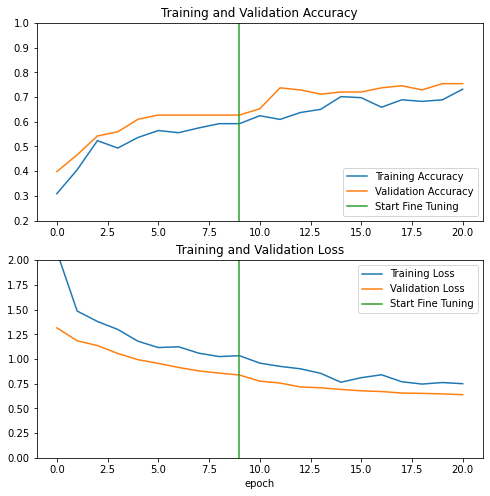

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
#TODO: save model and convert to TF.js